In [2]:
import statsmodels.api as sm
import pandas as pd
from typing import TypedDict

class LinearRegressionParameters(TypedDict):
  constant: float
  coefficient: float
  residuals: pd.Series

def time_series_linear_regression(
  target_values: pd.Series,
  independent_values: pd.Series
) -> LinearRegressionParameters:
  """
  Perform OLS regression for time series data.
  Model: target = constant + coefficient * independent + residual
  Args:
    target_values (pd.Series): dependent variable (e.g. ln(Y/K))
    independent_values (pd.Series): time variable or explanatory variable (e.g. year)
  Returns:
    dict: constant, coefficient, residuals
  """

  model = sm.OLS(
    target_values, 
    sm.add_constant(independent_values)
    ).fit()

  # 残差に時系列インデックスを保持
  residuals = model.resid
  residuals.index = target_values.index

  return {
    "constant": model.params["const"],
    "coefficient": model.params[independent_values.name],
    "residuals": residuals
  }


In [3]:
from statsmodels.tsa.filters.hp_filter import hpfilter
import pandas as pd
from typing import Literal

def hp_filter_trend(
    target_series: pd.Series,
    time_scale: Literal["yearly", "quarterly", "monthly"] = "yearly",
    with_cycle: bool | None = False
) -> pd.Series | tuple[pd.Series, pd.Series]:
    """
    Apply Hodrick-Prescott (HP) filter to extract the trend component
    from a time-series variable (e.g. productivity, utilization).
    Args:
        target_series (pd.Series): 時系列データ（インデックスは時系列）
        time_scale (str): "yearly", "quarterly", または "monthly"
    Returns:
        pd.Series: トレンド成分（trend component）
    """
    if time_scale == "yearly":
        lamb = 6.25
    elif time_scale == "quarterly":
        lamb = 1600
    elif time_scale == "monthly":
        lamb = 14400
    else:
        raise ValueError("time_scale must be 'yearly', 'quarterly', or 'monthly'.")

    cycle, trend = hpfilter(target_series, lamb=lamb)
    trend.index = target_series.index  # 元の時系列インデックスを保持
    if not with_cycle:
        return trend
    else:
        cycle.index = target_series.index 
        return cycle, trend
    


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def calculate_capacity_utilization(Y: pd.Series, K: pd.Series):
  """"
    In(Y/K) = C + γt + ut \n
    ut' = hp(ut) \n
    St = exp(ut' - u‾)
  """
  target_value = np.log( Y / K ).dropna()
  target_value.name = "gdp per capital"
  independent_values = pd.Series(target_value.index.astype(int), index=target_value.index, name="year")
  capital_utilization_values_by_real_surplus = time_series_linear_regression(target_value, independent_values)['residuals']

  # HPフィルターで滑らかにする
  smoothed_capital_utilization_values_by_real_surplus = hp_filter_trend(
    capital_utilization_values_by_real_surplus, "yearly"
  )

  # 平均をゼロに揃えてから指数化（基準平均を1にする）
  smoothed_capital_utilization_values_by_real_surplus = smoothed_capital_utilization_values_by_real_surplus - smoothed_capital_utilization_values_by_real_surplus.mean()
  S_t = np.exp(smoothed_capital_utilization_values_by_real_surplus)
  S_t.name = "capacity_utilization_ratio"

  return S_t


# GDP of manufacturing

In [5]:
import pandas as pd

# Unit : Million NT$

path = "./data/taiwan/tw_gdp_by_industry.xlsx"

gdp = pd.read_excel(path, sheet_name="Gross Domestic Product ", header=3, index_col=0)
gdp.columns = gdp.columns.astype(int)
manufacturing_gdp = gdp.iloc[6].apply(pd.to_numeric, errors="coerce") * 1000000
manufacturing_gdp.index.name = "year"
manufacturing_gdp.name = "Manufacturing GDP"


In [6]:
path = "./data/taiwan/tw_gdp_by_industry.xlsx"
# --- 1. デフレーター読み込み（製造業） ---
gdp_deflator = pd.read_excel(path, sheet_name="Price Deflators for GDP", header=3, index_col=0)
# 2021=100
gdp_deflator.columns = gdp_deflator.columns.astype(int)
gdp_deflator = gdp_deflator.apply(pd.to_numeric, errors="coerce")

gdp_deflator_manufacturing = gdp_deflator.iloc[6].copy()
gdp_deflator_manufacturing.index.name = "year"
gdp_deflator_manufacturing.name = "deflator"
gdp_deflator_manufacturing = gdp_deflator_manufacturing.sort_index()  # 年順に

<Axes: title={'center': 'real gdp of manufacturing'}, xlabel='year', ylabel='NT$'>

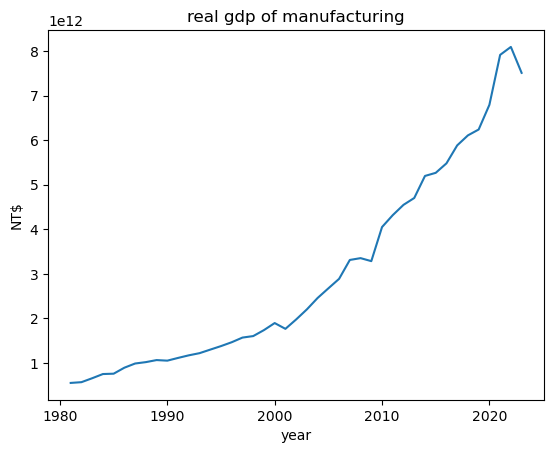

In [7]:
real_manufacturing_gdp = manufacturing_gdp * 100 / gdp_deflator_manufacturing
real_manufacturing_gdp.plot(title="real gdp of manufacturing", ylabel="NT$")

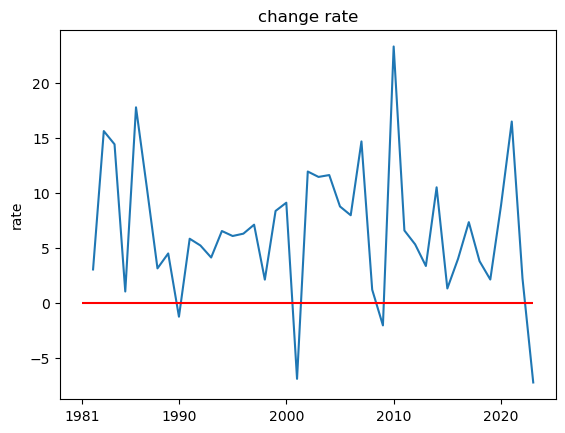

In [8]:
from matplotlib import pyplot as plt

gdp_manufacturing = real_manufacturing_gdp.copy()
gdp_manufacturing.index = gdp_manufacturing.index.astype(str)
plt.plot(gdp_manufacturing.pct_change()* 100)
plt.title("change rate")
plt.ylabel("rate")
plt.hlines(0, gdp_manufacturing.index[0], gdp_manufacturing.index[-1], color="red")
tick_positions = [0]
tick_lables = [gdp_manufacturing.index[0]]
for i, year in enumerate(gdp_manufacturing.index):
  if i == 0:
    continue
  if int(year) % 10 == 0:
    tick_positions.append(i)
    tick_lables.append(year)
plt.xticks(tick_positions, tick_lables)
plt.show()

# Labor

/opt/conda/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


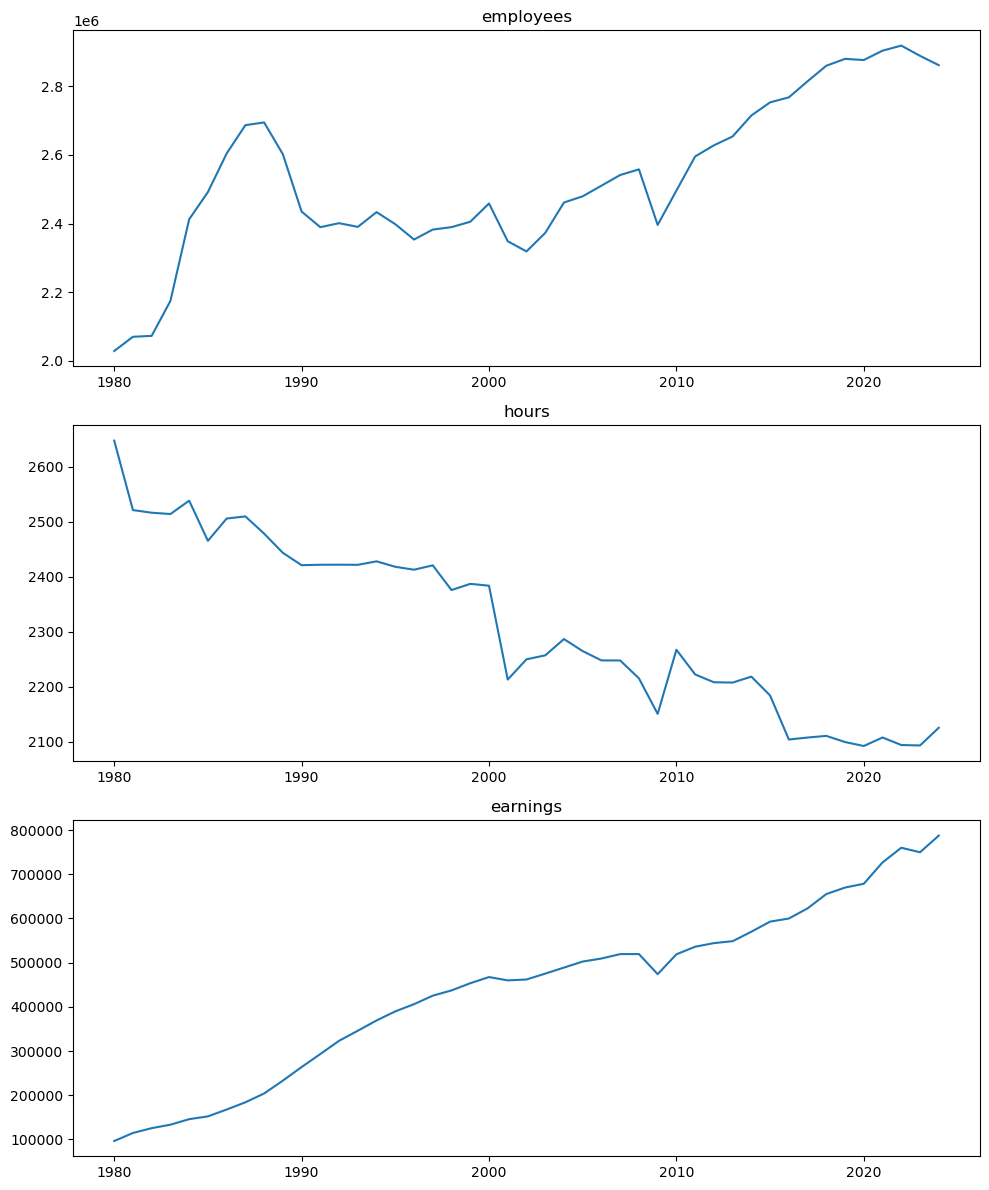

In [9]:
import pandas as pd
from typing import Literal
from matplotlib import pyplot as plt

path = "./data/taiwan/tw_laborers_hours_earnings.xlsx"
df = pd.read_excel(path, index_col=0)

average_monthly_earnings = df.iloc[2:542].reset_index(drop=True)
# NT$
employee = df.iloc[550:1090].reset_index(drop=True)
average_monthly_working_hours = df.iloc[1098:1638].reset_index(drop=True)

average_monthly_earnings.columns = ["month", "value"]
employee.columns = ["month", "value"]
average_monthly_working_hours.columns = ["month", "value"]

def to_yearly_data(monthly_data: pd.DataFrame, agg: Literal["sum", "mean"]) -> pd.DataFrame:
  yearly_data = (
    monthly_data
    .assign(year=monthly_data["month"].astype(str).str[:4])  # 'YYYY-MM' → 'YYYY'
    .groupby("year")["value"]
    .agg(agg)                      # mean=平均, sum=合計
    .reset_index()
  ).set_index("year", drop=True).apply(pd.to_numeric, errors="coerce")
  yearly_data.index = yearly_data.index.astype(int)

  return yearly_data

yearly_earnings = to_yearly_data(average_monthly_earnings, agg="sum")
yearly_employee = to_yearly_data(employee, agg="mean")
yearly_working_hours = to_yearly_data(average_monthly_working_hours, agg="sum")
smoothed_working_hours = hp_filter_trend(yearly_working_hours, "yearly")


labor_input = yearly_employee["value"] * smoothed_working_hours
labor_input = labor_input.loc[1981: 2023]

fig, ax  = plt.subplots(3, 1, figsize=(10, 12))
ax[0].plot(yearly_employee)
ax[0].set_title("employees")

ax[1].plot(yearly_working_hours)
ax[1].set_title("hours")
ax[2].plot(yearly_earnings)
ax[2].set_title("earnings")
fig.tight_layout()
plt.show()

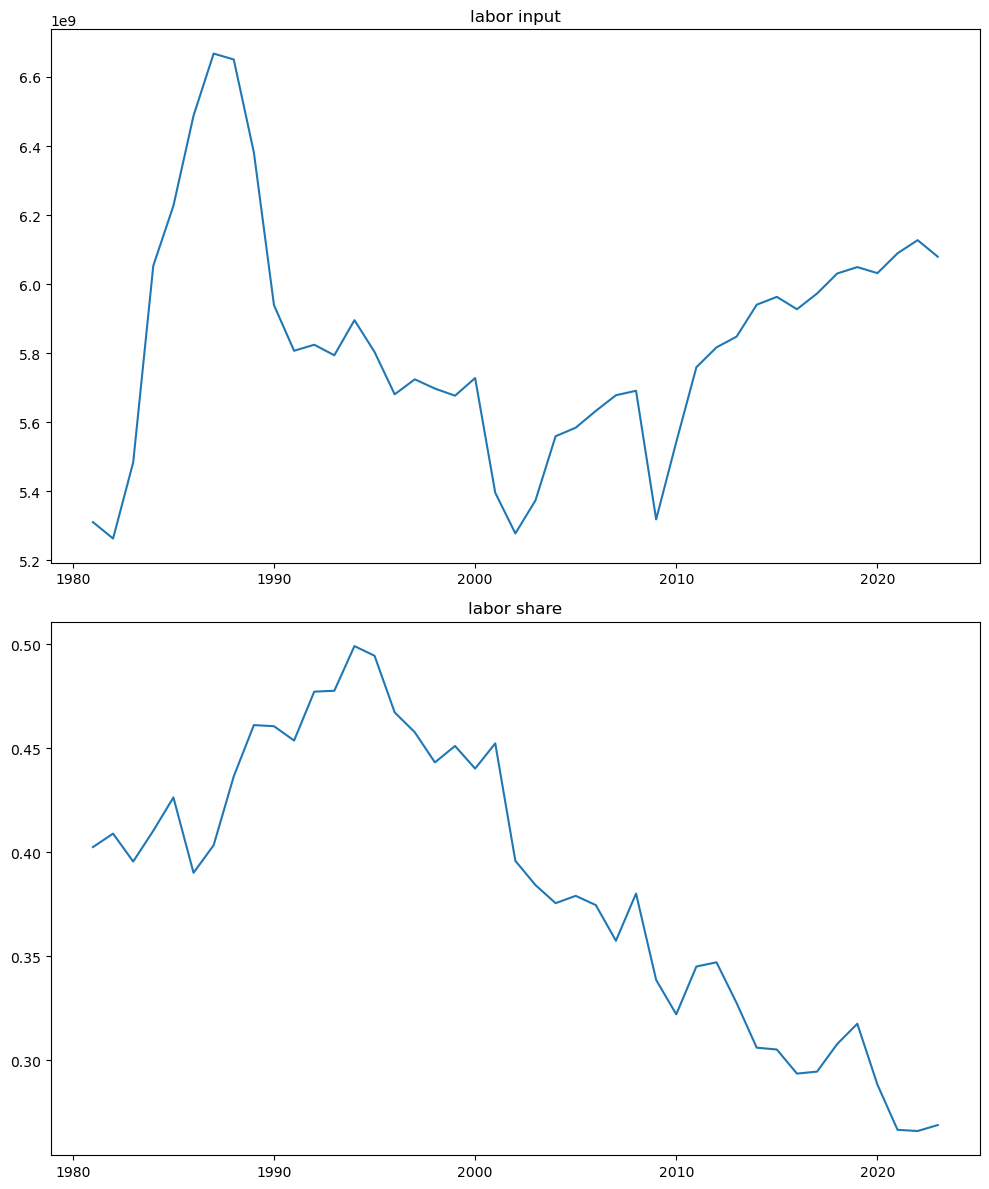

In [10]:
from matplotlib import pyplot as plt

labor_compensation = yearly_earnings * yearly_employee
labor_share = labor_compensation.loc[1981:2023]["value"] / manufacturing_gdp

fig, ax  = plt.subplots(2, 1, figsize=(10, 12))
ax[0].plot(labor_input)
ax[0].set_title("labor input")
ax[1].plot(labor_share)
ax[1].set_title("labor share")
fig.tight_layout()
plt.show()

# Capital

<Axes: title={'center': 'average depreciation rate'}, xlabel='year', ylabel='rate'>

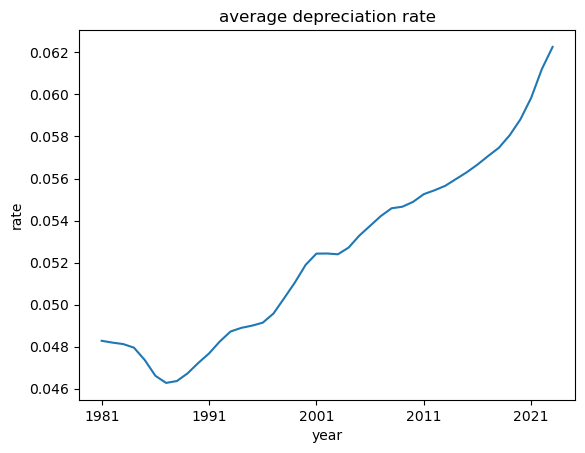

In [11]:
# https://www.moea.gov.tw/MNS/DOS_E/content/wHandMenuFile.ashx?file_id=37489 
# Feenstra, Robert C., Robert Inklaar and Marcel P. Timmer (2015), "The Next Generation of the Penn World Table" American Economic Review, 105(10), 3150-3182, available for download at www.ggdc.net/pwt


path = "./data/taiwan/tw_average_depreciation_rate.csv"
depreciation_rate = pd.read_csv(path, header=0, index_col=0).loc["TWN", "1981": ].apply(pd.to_numeric, errors="coerce")

depreciation_rate.plot(title="average depreciation rate", ylabel="rate", xlabel="year")

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


<Axes: xlabel='year'>

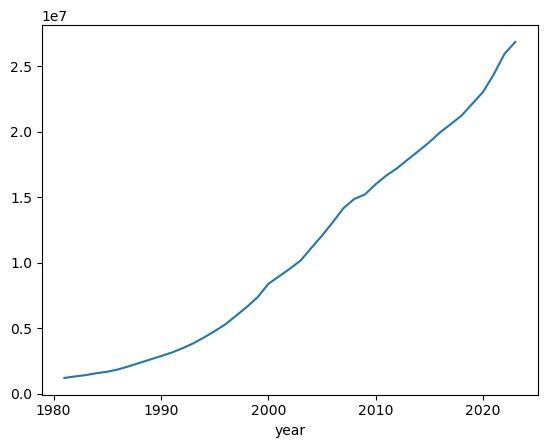

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter

# https://data.gov.tw/en/datasets/45042
# nominal value is denoted by 100 million NT$
path_gfcf = "./data/taiwan/tw_gross_fixed_capital_formation.csv"

# --- 2. GFCF 読込（名目） ---
gfcf_df = pd.read_csv(path_gfcf, index_col=0, encoding="utf-8")
# フィルタして対象行を取り出す（元のラベルに合わせて）
gfcf = gfcf_df[
  gfcf_df["TYPE"] == "原始值"
].loc["連鎖實質值(2021為參考年_新臺幣百萬元)、C.製造業_固定資本形成:1--4合計", ["TIME_PERIOD", "Item_VALUE"]]

gfcf.columns = ["year", "real_value"]
gfcf["year"] = gfcf["year"].astype(int)
gfcf["real_value"] = pd.to_numeric(gfcf["real_value"], errors="coerce") 
gfcf = gfcf.set_index("year").sort_index()

# --- 4. 投資成長率 g の推定 ---
smoothed_I = hp_filter_trend(gfcf["real_value"], "yearly")

# 最初の5年を除いて、次の10年の平均成長率を使用
gI = smoothed_I.pct_change().iloc[5:15].mean()

# --- 5. 初期ストック K0 の設定（K0 = I0 / (g + delta)） ---
I0 = gfcf["real_value"].iloc[0]

delta = depreciation_rate.copy()
# https://scispace.com/pdf/estimating-aggregate-capital-stocks-using-the-perpetual-3k8wcmlp0f.pdf
K0 = I0 / (gI + delta.iloc[0])

# --- 6. 永続在庫法で推計（net capital stock: 減耗考慮済） ---
K = [K0]
for t in range(1, len(gfcf)):
  K_t = (1 - delta.iloc[t]) * K[-1] + gfcf["real_value"].iloc[t]
  K.append(K_t)

gfcf["real_net_capital_stock"] = K
real_net_capital_stock = pd.Series(K, index=gfcf.index, name="real net capital stock")
real_net_capital_stock.plot()

year
1981    1.159986
1982    1.189367
1983    1.222905
1984    1.253213
1985    1.272295
1986    1.277489
1987    1.259650
1988    1.218643
1989    1.164098
1990    1.105921
1991    1.052870
1992    1.005780
1993    0.963648
1994    0.925557
1995    0.889744
1996    0.854646
1997    0.819427
1998    0.785106
1999    0.755053
2000    0.730982
2001    0.716368
2002    0.716912
2003    0.729143
2004    0.747331
2005    0.767651
2006    0.789081
2007    0.812333
2008    0.837519
2009    0.869850
2010    0.912879
2011    0.957696
2012    0.999576
2013    1.037173
2014    1.071500
2015    1.101159
2016    1.129991
2017    1.160868
2018    1.193244
2019    1.227653
2020    1.264120
2021    1.294523
2022    1.307849
2023    1.308580
Name: capacity_utilization_ratio, dtype: float64


/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


<Axes: xlabel='year'>

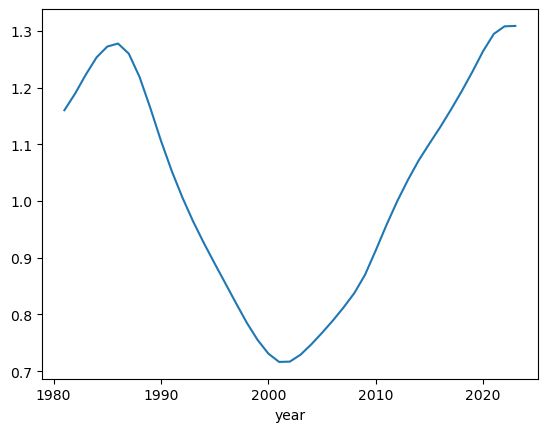

In [13]:
capacity_utilization = calculate_capacity_utilization(real_manufacturing_gdp, real_net_capital_stock)
capacity_input = real_net_capital_stock * capacity_utilization
print(capacity_utilization)
capacity_utilization.plot()

# Growth accounting

/opt/conda/lib/python3.13/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


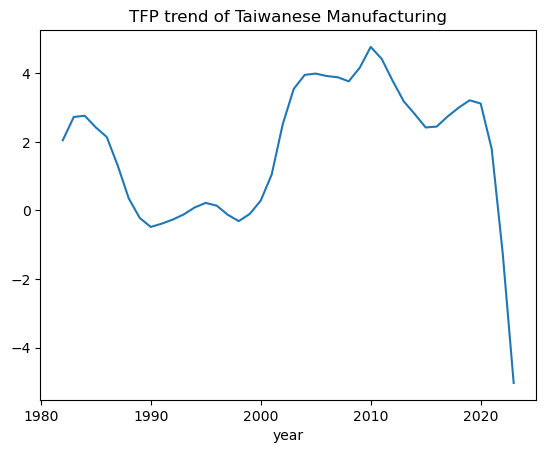

<Figure size 1000x600 with 0 Axes>

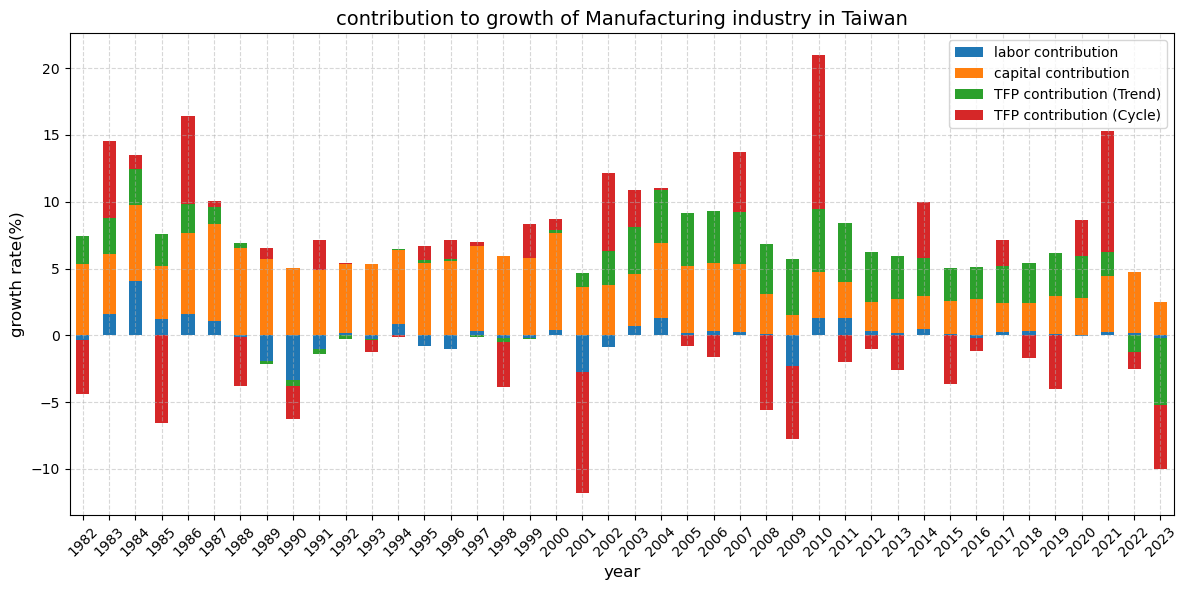

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def growth_accounting_calculator(Y, K, L, labor_share):
  gY = np.log(Y).diff().dropna()
  gK = np.log(K).diff().dropna()
  gL = np.log(L).diff().dropna()

  alpha = 1 - labor_share.loc[gL.index]  
  gA = gY - ((1 - alpha) * gL + alpha * gK)
  cycle, trend = hp_filter_trend(gA, "yearly", True)

  # 成長寄与度を計算（単位：%）
  labor_contrib = (1 - alpha) * gL * 100
  capital_contrib = alpha * gK * 100

  # データをまとめる
  df = pd.DataFrame({
    'labor contribution': labor_contrib,
    'capital contribution': capital_contrib,
    'TFP contribution (Trend)': trend * 100,
    'TFP contribution (Cycle)': cycle * 100
  }, index=Y.index).dropna()
  return df

def plotter(df: pd.DataFrame):
  # プロット
  plt.figure(figsize=(10,6))
  df.plot(kind='bar', stacked=True, figsize=(12,6))

  plt.title("contribution to growth of Manufacturing industry in Taiwan", fontsize=14)
  plt.xlabel("year", fontsize=12)
  plt.ylabel("growth rate(%)", fontsize=12)
  plt.xticks(rotation=45)
  plt.legend(loc='best')
  plt.grid(True, linestyle='--', alpha=0.5)
  plt.tight_layout()
  plt.show()

growth_accounting = growth_accounting_calculator(real_manufacturing_gdp, real_net_capital_stock, labor_input, labor_share)

growth_accounting["TFP contribution (Trend)"].plot(title="TFP trend of Taiwanese Manufacturing")
plotter(growth_accounting)


In [18]:
import pandas as pd
from pathlib import Path

# 保存先のパスをPathオブジェクトとして定義
# 現在のディレクトリからの相対パス
output_dir = Path('./analysis/result/tw_manufac') 
output_file = output_dir / 'growth_accounting.csv' # スラッシュでパスを結合できる
output_df = growth_accounting.copy()
output_df.insert(0, "year", output_df.index)

# 親フォルダーが存在しない場合は作成する (parents=Trueで階層があってもOK)
output_dir.mkdir(parents=True, exist_ok=True)

# CSVとして保存
output_df.to_csv(output_file, index=False, encoding='utf-8')


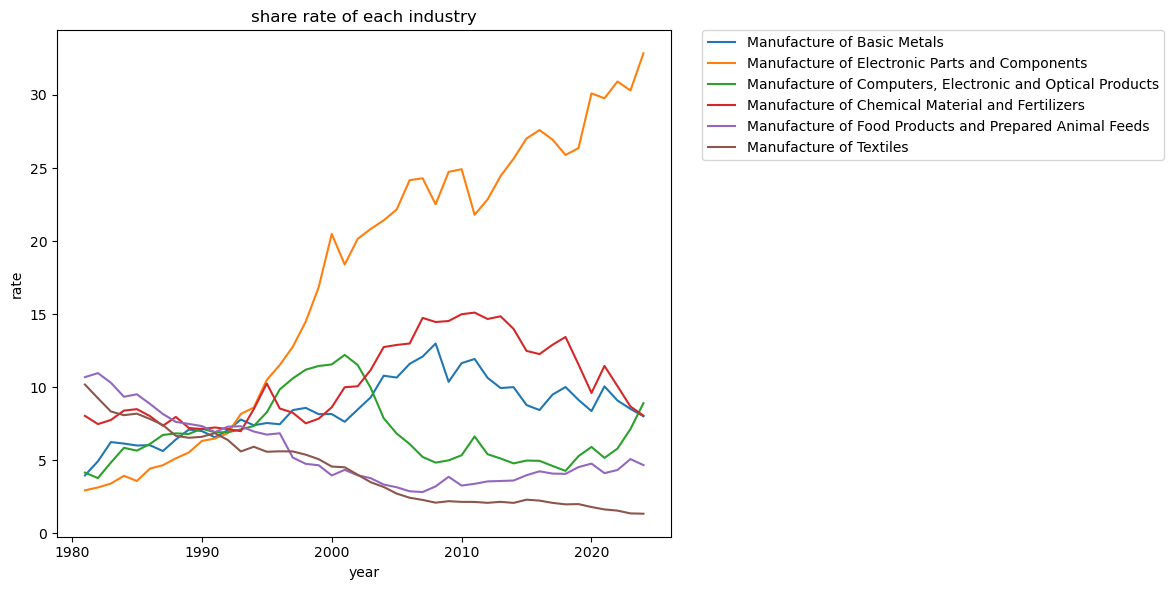

In [16]:
import pandas as pd
from matplotlib import pyplot as plt

output_by_industry = pd.read_excel("./data/taiwan/tw_production_by_industry.xlsx", header=2, index_col=0, nrows=44).dropna(axis=1).apply(pd.to_numeric, errors="coerce")
output_by_industry.columns = ["Manufacture Total",  *output_by_industry.columns[1:]]
share_by_industry = {}
for col in output_by_industry.columns:
  share_series = output_by_industry[col] / output_by_industry["Manufacture Total"]
  if share_series.apply(lambda x: x >= 0.1).any():
    share_by_industry[col] = share_series
share_by_industry = pd.DataFrame(share_by_industry, index=output_by_industry.index)
share_by_industry = share_by_industry.drop("Manufacture Total", axis=1) * 100

ax = share_by_industry.plot(figsize=(12, 6))

# 凡例をプロットの外に配置 (右上に配置)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title("share rate of each industry")
plt.ylabel("rate")
plt.xlabel("year")
plt.tight_layout()
plt.show()

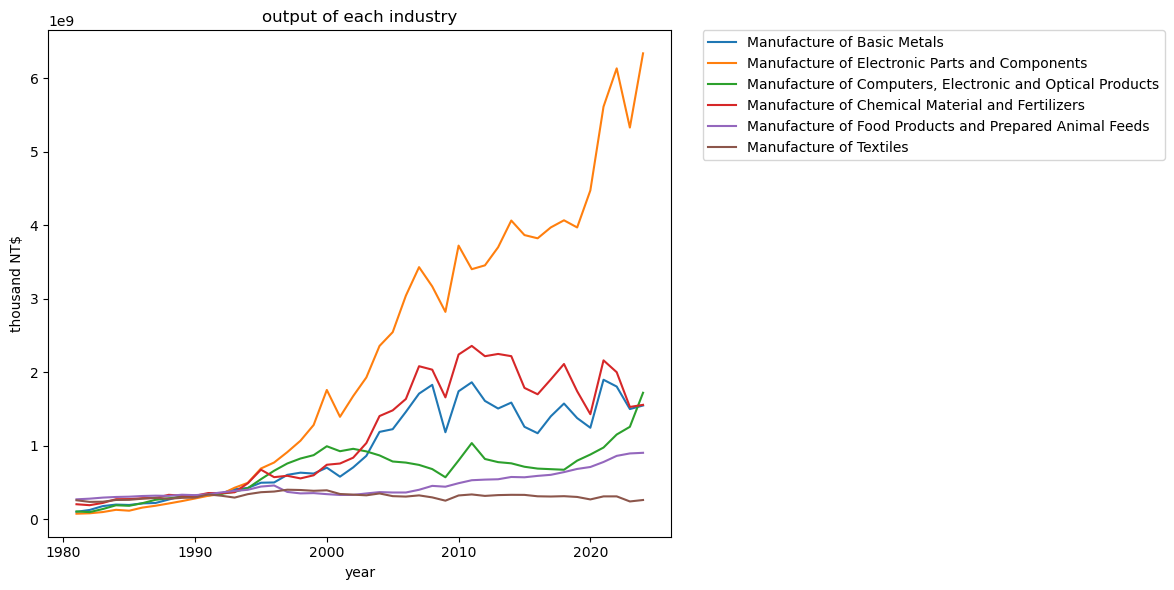

In [17]:

ax = output_by_industry[share_by_industry.columns].plot(figsize=(12, 6))

# 凡例をプロットの外に配置 (右上に配置)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.title("output of each industry")
plt.ylabel("thousand NT$")
plt.xlabel("year")
plt.tight_layout()
plt.show()